In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing Libraries and Read Dataset**

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [6]:
def load_ICU_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
                    'marital_status', 'occupation', 'relationship', 'race', 'sex', 
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names, 
                              na_values="?", sep=r'\s*,\s*', engine='python') # here seperator -- 0 or more whitespace then , then 0 or more whitespace --
                              .loc[lambda df: df['race'].isin(['White', 'Black'])])

    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attribs = ['race', 'sex']
    Z = (input_data.loc[:, sensitive_attribs]
         .assign(race=lambda df: (df['race'] == 'White').astype(int),
                 sex=lambda df: (df['sex'] == 'Male').astype(int)))

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target'] == '>50K').astype(int) # Cast a pandas object to a specified dtype dtype.

    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
         .drop(columns=['target', 'race', 'sex'])
         .fillna('Unknown')   # The fillna() function is used to fill NA/NaN values using the specified method
         .pipe(pd.get_dummies, drop_first=True)) # Use .pipe when chaining together functions that expect Series, DataFrames or GroupBy objects.
                                                 # pd.get_dummies=Convert categorical variable into dummy/indicator variables
                                                 # drop_first: bool function(default False) Whether to get k-1 dummies out of k categorical levels by removing the first level.
    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape[0]} samples")
    print(f"sensitives Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X, y, Z, input_data

In [7]:
X, y, Z, df = load_ICU_data('/content/drive/MyDrive/CSML/Fariness in ML/adult.data')

features X: 30940 samples, 94 attributes
targets y: 30940 samples
sensitives Z: 30940 samples, 2 attributes


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30940 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30940 non-null  int64 
 1   workclass       29217 non-null  object
 2   fnlwgt          30940 non-null  int64 
 3   education       30940 non-null  object
 4   education_num   30940 non-null  int64 
 5   marital_status  30940 non-null  object
 6   occupation      29210 non-null  object
 7   relationship    30940 non-null  object
 8   race            30940 non-null  object
 9   sex             30940 non-null  object
 10  capital_gain    30940 non-null  int64 
 11  capital_loss    30940 non-null  int64 
 12  hours_per_week  30940 non-null  int64 
 13  country         30458 non-null  object
 14  target          30940 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.8+ MB


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,30940.0,38.668714,13.685619,17.0,28.0,37.0,48.0,90.0
fnlwgt,30940.0,191409.048352,106082.504618,18827.0,119170.0,180281.5,238404.5,1484705.0
education_num,30940.0,10.069716,2.551595,1.0,9.0,10.0,12.0,16.0
capital_gain,30940.0,1069.992211,7302.167330,0.0,0.0,0.0,0.0,99999.0
capital_loss,30940.0,87.734551,404.123725,0.0,0.0,0.0,0.0,4356.0
hours_per_week,30940.0,40.460278,12.356746,1.0,40.0,40.0,45.0,99.0


In [10]:
df.nunique()

age                  73
workclass             8
fnlwgt            20674
education            16
education_num        16
marital_status        7
occupation           14
relationship          6
race                  2
sex                   2
capital_gain        119
capital_loss         89
hours_per_week       94
country              40
target                2
dtype: int64

# **Cleaning the dataset**

**Checking duplicate rows**

In [11]:
df.duplicated().sum()

23

**Dropping the duplicate rows**

In [12]:
df.drop_duplicates(inplace= True)

**Checking null values for each column**

In [13]:
df.isnull().sum(axis = 0)

age                  0
workclass         1723
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1730
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
country            481
target               0
dtype: int64

In [15]:
print(df.shape)
df.head()

(30917, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# **Dataset Visualization**

Text(0.0, 1.0, 'Dataset Correlation')

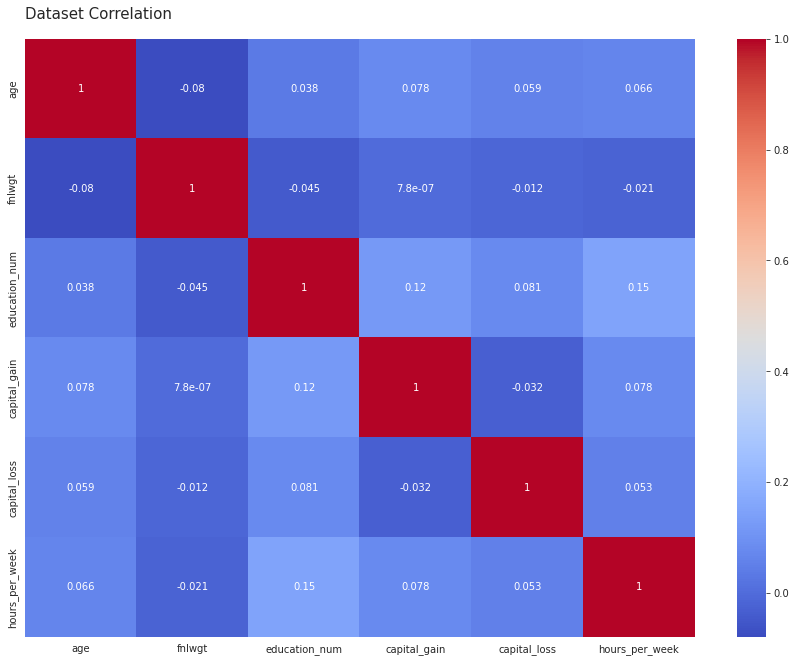

In [16]:
sns.set_style('whitegrid')
plt.figure(figsize=(15,11))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Dataset Correlation', loc='left', pad=20, fontsize=15)

In [17]:
def plot_stats(df, column, ax, color, angle):
  count_classes = df[column].value_counts()
  ax = sns.barplot(x=count_classes.index, y=count_classes, ax=ax, palette=color)
  ax.set_title(column.upper(), fontsize=18)
  for tick in ax.get_xticklabels():
    tick.set_rotation(angle)

**Age in the dataset**

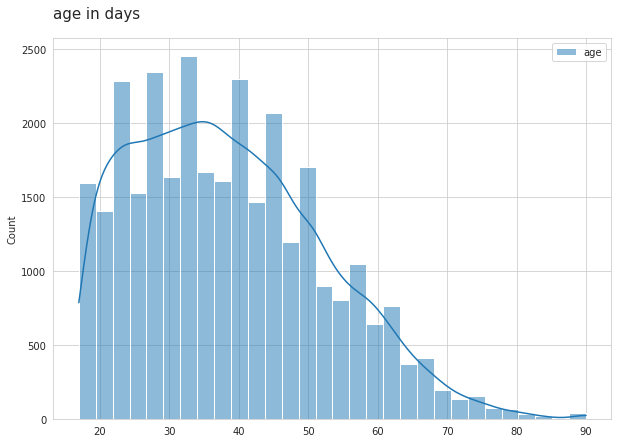

In [18]:
plt.figure(figsize=(10, 7));
sns.histplot(df[['age']],bins=30,kde=True, color='b');
plt.title('age in days', loc='left', fontsize=15, pad=20);

**Gender**

---
1.   Female
2.   Male

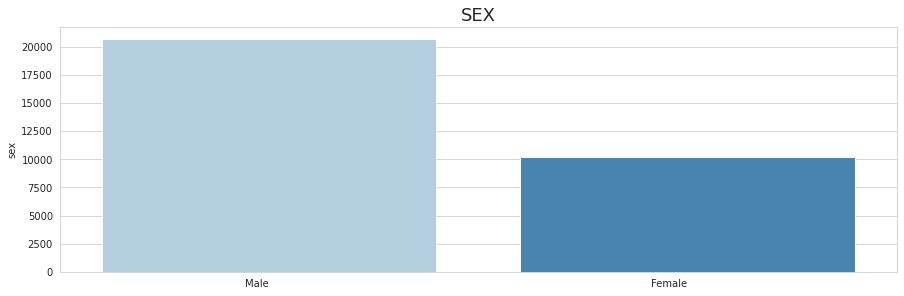

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
fig.autofmt_xdate()
plot_stats(df, "sex", axes, "Blues", 0)
plt.show()

# Chi-Squared statistical test

**Implement a Chi-Squared statistical test for non-negative features to select 5 of the best features from the dataset**

In [27]:
print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
print(f"targets y: {y.shape[0]} samples")

features X: 30940 samples, 94 attributes
targets y: 30940 samples


In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np
colname = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 
           'marital_status', 'occupation', 'relationship', 'race', 'sex', 
           'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']

test = SelectKBest(score_func=chi2, k=5)
fit = test.fit(X, y)

feature_score = dict(zip(colname,fit.scores_))
sorted(feature_score.items(), key=lambda x:x[1])

[('relationship', 2.2413381123058542),
 ('country', 4.162485065710872),
 ('capital_loss', 5.7347707638190615),
 ('capital_gain', 22.54712070530599),
 ('occupation', 33.395105263427126),
 ('race', 57.363463711476754),
 ('hours_per_week', 175.78558496943373),
 ('target', 226.96498249466975),
 ('sex', 582.1986632023627),
 ('fnlwgt', 2257.7912619839126),
 ('marital_status', 6221.865742551707),
 ('age', 8269.428659199722),
 ('workclass', 284862.04379342863),
 ('education_num', 1307339.5685026527),
 ('education', 76437031.82667425)]

# **Simple Model**

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [22]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=1)
scaler = StandardScaler()
X_train1 = scaler.fit_transform(X_train1)
X_test1 = scaler.transform(X_test1)

In [23]:
models1 = {"Logistic Regression": LogisticRegression(),
          "KNN" : KNeighborsClassifier(n_neighbors=50),
          "Decision tree" : DecisionTreeClassifier(),
          "Naive bayes" : GaussianNB(),
          "Linear SVM" : SVC(kernel='linear'),
          "Gaussian SVM" : SVC(kernel='rbf'),
          "Random forest" : RandomForestClassifier(n_estimators=100)}

In [24]:
accuracy1 = []
for i in models1.values():
  model = i
  model.fit(X_train1, y_train1)
  model_pred = model.predict(X_test1)
  accuracy1.append(accuracy_score(y_test1, model_pred))

In [25]:
for i,j in zip(models1, accuracy1):
  print(i,": ",j)

Logistic Regression :  0.8490627020038785
KNN :  0.8188429217840982
Decision tree :  0.8059146735617324
Naive bayes :  0.4964447317388494
Linear SVM :  0.8450226244343891
Gaussian SVM :  0.8427601809954751
Random forest :  0.8490627020038785


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

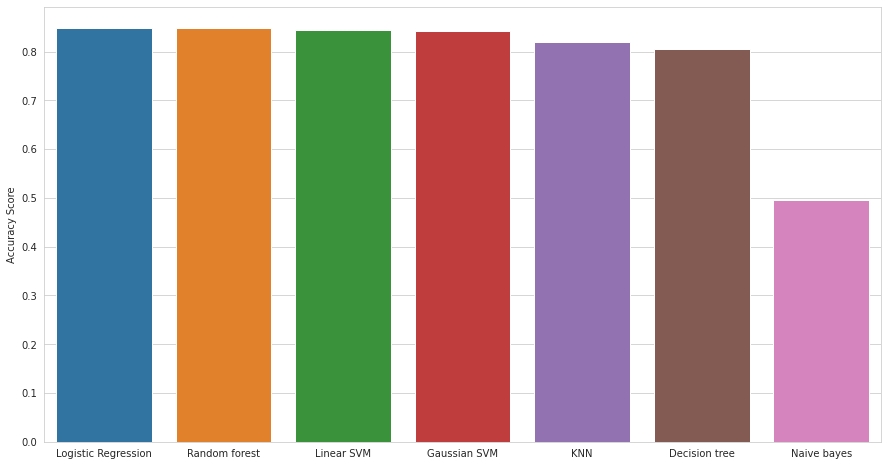

In [26]:
scores = dict(zip(list(models1.keys()), accuracy1))
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
scores_frame

plt.figure(figsize=(15,8))
sns.barplot(x=scores_frame.index, y=scores_frame["Accuracy Score"])
plt.xticks(rotation=0)

# **Principal Component Analysis (PCA)**

**Mean centering**

In [ ]:
#X = df[['gender', 'ap_hi', 'ap_lo','cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_year', 'bmi']]
X3 = df[['ap_hi', 'ap_lo','cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age', 'bmi']]
X3 = X3.subtract(X3.mean())
y3 = df['cardio']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=1)

scaler = StandardScaler()
X_train3 = scaler.fit_transform(X_train3)
X_test3 = scaler.transform(X_test3)

In [ ]:
models3 = {"Logistic Regression": LogisticRegression(),
          "KNN" : KNeighborsClassifier(n_neighbors=50),
          "Decision tree" : DecisionTreeClassifier(),
          "Naive bayes" : GaussianNB(),
          "Linear SVM" : SVC(kernel='linear'),
          "Gaussian SVM" : SVC(kernel='rbf'),
          "Random forest" : RandomForestClassifier(n_estimators=100)}

In [ ]:
from sklearn import decomposition
import numpy as np
import plotly.graph_objects as go

pca = decomposition.PCA()
pca.n_components = 2
pca_data = pca.fit_transform(X_train3)

pca_data = np.vstack((pca_data.T, y_train3)).T
pca_df = pd.DataFrame(data = pca_data, columns = ('first', 'second', 'label'))

fig = go.Figure(data=go.Scattergl(
    x = pca_df['first'], 
    y = pca_df['second'],
    mode='markers',
    marker_color=pca_df['label']
))

fig.show()

In [ ]:
listmodels3 = ["Logistic Regression", "KNN", "Decision tree", "Naive bayes", "Linear SVM", "Gaussian SVM", "Random forest"]
accuracy3 = []
for i in range(2,9):
  pca = decomposition.PCA()
  pca.n_components = i
  pca_X_train = pca.fit_transform(X_train3)
  pca_X_test = pca.fit_transform(X_test3)

  j=0
  print("Dimension: ",pca_X_train.shape[1])
  for i in models3.values():
    model = i
    model.fit(pca_X_train, y_train3)
    model_pred = model.predict(pca_X_test)
    res = accuracy_score(y_test3, model_pred)
    accuracy3.append([listmodels3[j],pca_X_train.shape,res])

    print(listmodels3[j]," = ",res)
    j = j+1
  
  print("-----------------------------------------------------")

Dimension:  2
Logistic Regression  =  0.6595605355064028
KNN  =  0.6752037252619325
Decision tree  =  0.579452852153667
Naive bayes  =  0.6378783469150174
Linear SVM  =  0.6483556461001164
Gaussian SVM  =  0.6774592549476135
Random forest  =  0.6297293364377182
-----------------------------------------------------
Dimension:  3
Logistic Regression  =  0.689173457508731
KNN  =  0.680151338766007
Decision tree  =  0.5891298020954598
Naive bayes  =  0.6744761350407451
Linear SVM  =  0.6896100116414435
Gaussian SVM  =  0.6914289871944121
Random forest  =  0.6587601862630966
-----------------------------------------------------
Dimension:  4
Logistic Regression  =  0.6889551804423748
KNN  =  0.6372235157159488
Decision tree  =  0.5510040745052387
Naive bayes  =  0.6736757857974389
Linear SVM  =  0.6893917345750873
Gaussian SVM  =  0.6266006984866124
Random forest  =  0.643408032596042
-----------------------------------------------------
Dimension:  5
Logistic Regression  =  0.6495925494761

In [ ]:
accuracy3.sort(key=lambda x: x[0])
accuracy3

[['Decision tree', (54976, 2), 0.579452852153667],
 ['Decision tree', (54976, 3), 0.5891298020954598],
 ['Decision tree', (54976, 4), 0.5510040745052387],
 ['Decision tree', (54976, 5), 0.552313736903376],
 ['Decision tree', (54976, 6), 0.569557625145518],
 ['Decision tree', (54976, 7), 0.5442374854481956],
 ['Decision tree', (54976, 8), 0.5496944121071012],
 ['Gaussian SVM', (54976, 2), 0.6774592549476135],
 ['Gaussian SVM', (54976, 3), 0.6914289871944121],
 ['Gaussian SVM', (54976, 4), 0.6266006984866124],
 ['Gaussian SVM', (54976, 5), 0.5982974388824214],
 ['Gaussian SVM', (54976, 6), 0.6347497089639115],
 ['Gaussian SVM', (54976, 7), 0.5950960419091967],
 ['Gaussian SVM', (54976, 8), 0.5980064027939465],
 ['KNN', (54976, 2), 0.6752037252619325],
 ['KNN', (54976, 3), 0.680151338766007],
 ['KNN', (54976, 4), 0.6372235157159488],
 ['KNN', (54976, 5), 0.6514115250291036],
 ['KNN', (54976, 6), 0.6731664726426076],
 ['KNN', (54976, 7), 0.6621071012805588],
 ['KNN', (54976, 8), 0.66261641

# **Linear Discriminant Analysis (LDA)**

**Mean centering**

In [ ]:
#X = df[['gender', 'ap_hi', 'ap_lo','cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_year', 'bmi']]
X5 = df[['ap_hi', 'ap_lo','cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age', 'bmi']]
X5 = X5.subtract(X5.mean())
y5 = df['cardio']
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.2, random_state=1)

scaler = StandardScaler()
X_train5 = scaler.fit_transform(X_train5)
X_test5 = scaler.transform(X_test5)

In [ ]:
models5 = {"Logistic Regression": LogisticRegression(),
          "KNN" : KNeighborsClassifier(n_neighbors=50),
          "Decision tree" : DecisionTreeClassifier(),
          "Naive bayes" : GaussianNB(),
          "Linear SVM" : SVC(kernel='linear'),
          "Gaussian SVM" : SVC(kernel='rbf'),
          "Random forest" : RandomForestClassifier(n_estimators=100)}

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
lda_X_train = lda.fit_transform(X_train5, y_train5)
lda_X_test = lda.transform(X_test5)

accuracy5 = []
for i in models5.values():
  model = i
  model.fit(lda_X_train, y_train5)
  model_pred = model.predict(lda_X_test)
  accuracy5.append(accuracy_score(y_test5, model_pred))


In [ ]:
for i,j in zip(models5, accuracy5):
  print(i,": ",j)

Logistic Regression :  0.697104190919674
KNN :  0.6893189755529686
Decision tree :  0.5953870779976718
Naive bayes :  0.6961583236321304
Linear SVM :  0.6984138533178114
Gaussian SVM :  0.697395227008149
Random forest :  0.5957508731082655


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

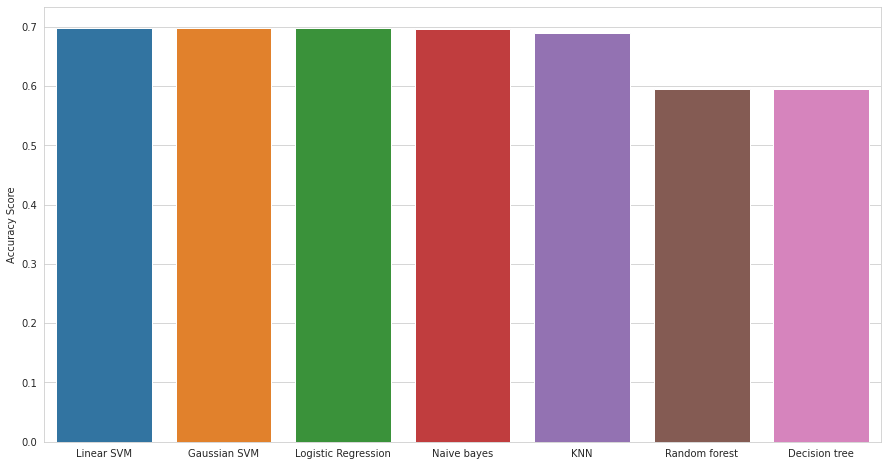

In [ ]:
scores = dict(zip(list(models5.keys()), accuracy5))
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
scores_frame

plt.figure(figsize=(15,8))
sns.barplot(x=scores_frame.index, y=scores_frame["Accuracy Score"])
plt.xticks(rotation=0)